<h1><b>Preprocessing and augmentation</b></h1>

In [1]:
!pip install split-folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders

In [2]:
from google.colab import files
dataset = files.upload()

Saving dataset.zip to dataset.zip


In [3]:
!unzip -q dataset.zip

In [4]:
splitfolders.ratio(
    'dataset',
    output='train_val_test',
    seed=42,
    ratio=(0.7, 0.15, 0.15),
    group_prefix=None,
    move=False
)

Copying files: 1944 files [00:00, 8525.12 files/s]


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Correct placement
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [23]:
train_generator = train_datagen.flow_from_directory(
    'train_val_test/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'train_val_test/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'train_val_test/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1354 images belonging to 15 classes.
Found 284 images belonging to 15 classes.
Found 306 images belonging to 15 classes.


In [13]:
from tensorflow.keras.applications.efficientnet import preprocess_input
train_generator = preprocess_input(train_generator)
val_generator = preprocess_input(val_generator)

In [34]:
import json
with open('class_names.json', 'w') as f:
    json.dump(test_generator.class_indices, f)
files.download('class_names.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<h1><b>Build the model with transfer learning</b></h1>

In [24]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [25]:
 #load pre-trained model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

In [26]:
from tensorflow.keras.regularizers import l2

#custom layers
inputs = base_model.input
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation='softmax')(x)

model = Model(inputs, outputs)

In [27]:
#complie
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

<h1><b>Train the model</b></h1>

In [28]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 53s 811ms/step - accuracy: 0.3601 - loss: 2.5230 - val_accuracy: 0.9570 - val_loss: 0.8037
Epoch 2/20
 1/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8125 - loss: 1.2023

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8125 - loss: 1.2023 - val_accuracy: 0.9297 - val_loss: 0.8128
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 424ms/step - accuracy: 0.8111 - loss: 1.0911 - val_accuracy: 0.9766 - val_loss: 0.6099
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8438 - loss: 0.9631 - val_accuracy: 0.9727 - val_loss: 0.5998
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 487ms/step - accuracy: 0.8557 - loss: 0.9135 - val_accuracy: 0.9727 - val_loss: 0.5499
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8750 - loss: 0.7896 - val_accuracy: 0.9727 - val_loss: 0.5571
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 434ms/step - accuracy: 0.8741 - loss: 0.8219 - val_accuracy: 0.9766 - val_loss: 0.5178
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.8038 - val_accuracy: 0.9688 - val_loss: 0.5243
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 410ms/step - accuracy: 0.9056 - loss: 0.7384 - val_accuracy: 0.9883 - val_

<h1><b>Fine tuning</b></h1>

In [30]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8749 - loss: 0.8261 - val_accuracy: 1.0000 - val_loss: 0.3639
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.6542 - val_accuracy: 1.0000 - val_loss: 0.3646
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 450ms/step - accuracy: 0.9387 - loss: 0.5700 - val_accuracy: 1.0000 - val_loss: 0.3591
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9375 - loss: 0.6051 - val_accuracy: 1.0000 - val_loss: 0.3596
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - accuracy: 0.9546 - loss: 0.5000 - val_accuracy: 1.0000 - val_loss: 0.3530
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9000 - loss: 0.7667 - val_accuracy: 1.0000 - val_loss: 0.3532
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 469ms/step - accuracy: 0.9548 - loss: 0.4852 - val_accuracy: 1.0000 - val_loss: 0.3478
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9062 - loss: 0.5689 - val_accuracy: 1.000

<h1><b>Plot & Evaluate

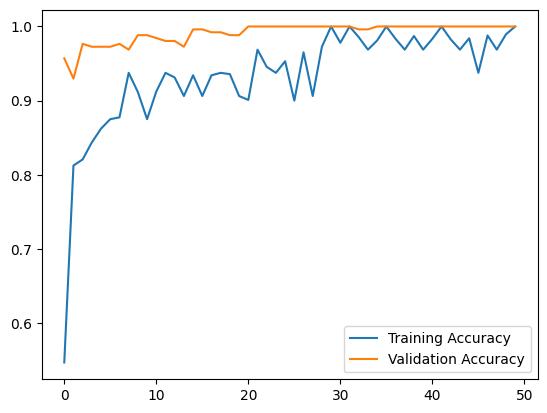

In [31]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [32]:
# Evaluate
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9965 - loss: 0.3044
Test Accuracy: 99.65%


In [33]:
import numpy as np
preds = model.predict(test_generator, steps=test_generator.samples // 32 + 1)
pred_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
from sklearn.metrics import classification_report
print(classification_report(true_classes, pred_classes, target_names=test_generator.class_indices.keys()))

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 724ms/step
              precision    recall  f1-score   support

        Bear       1.00      1.00      1.00        20
        Bird       1.00      1.00      1.00        22
         Cat       1.00      1.00      1.00        19
         Cow       1.00      1.00      1.00        21
        Deer       1.00      1.00      1.00        20
         Dog       1.00      0.95      0.97        19
     Dolphin       1.00      1.00      1.00        20
    Elephant       1.00      1.00      1.00        21
     Giraffe       1.00      1.00      1.00        20
       Horse       1.00      1.00      1.00        20
    Kangaroo       1.00      1.00      1.00        20
        Lion       0.95      1.00      0.98        21
       Panda       1.00      1.00      1.00        21
       Tiger       1.00      1.00      1.00        20
       Zebra       1.00      1.00      1.00        22

    accuracy                           1.00       306
   macro avg       1.00      1.00     

In [36]:
model.save('animal_classifier_model.h5')

In [37]:
from google.colab import files
files.download('animal_classifier_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>